Input dropout + Sparse

In [44]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from codes.utils import *
from codes.process import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [147]:
extract_train_type = 'test'
fold_num = 1
in_fold_num = 1
y_value = 'y'
ex_num = 100

In [148]:
bed_y_ex = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', extract_train_type, fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_y_ex = bed_y_ex.iloc[:, [1] + list(range(6, len(bed_y_ex.columns)))]

In [145]:
bed_y_ex

,IID,1:28875134:A:G_G,1:87968670:A:C_C,1:161477945:C:T_T,2:227817651:A:C_C,3:2436730:C:A_A,3:2439813:A:C_C,3:2526760:G:A_A,3:2543220:C:T_T,3:2549167:G:A_A,...,20:51352171:T:G_T,20:51353834:G:A_G,20:51355272:A:G_G,20:51356520:A:G_G,20:51361284:C:A_C,20:51363417:G:C_G,20:51367978:G:T_G,20:51371580:G:A_A,20:51371657:A:G_G,20:51372200:G:T_T
0,KNIHGR000009_KNIHGR000009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,KNIHGR000019_KNIHGR000019,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KNIHGR000051_KNIHGR000051,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,KNIHGR000070_KNIHGR000070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KNIHGR000121_KNIHGR000121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,KNIHGR009575_KNIHGR009575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,KNIHGR009587_KNIHGR009587,0,0,0,0,0,0,0,0,0,...,2,2,0,0,2,2,2,0,0,0
782,KNIHGR009589_KNIHGR009589,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,0,0
783,KNIHGR009597_KNIHGR009597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 일관된 출력을 위해 유사난수 초기화


# 맷플롯립 설정

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

[0, 1, 0, 0.95]

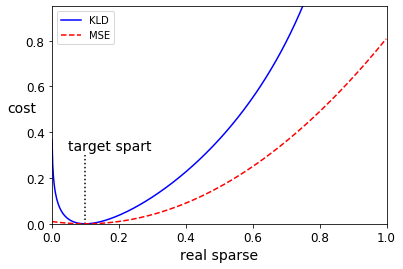

In [7]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "target spart", fontsize=14)
plt.plot(q, kl_div, "b-", label="KLD")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("real sparse")
plt.ylabel("cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
#save_fig("sparsity_loss_plot")

In [24]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

11493376/11490434 [==============================] - 1s 0us/step


In [29]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [33]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [39]:
def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.sigmoid) # 책에는 없음
outputs = tf.layers.dense(hidden1, n_outputs)                     # 책에는 없음

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

Instructions for updating:
Use keras.layers.dropout instead.


In [40]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 0.06527311 	희소 손실: 0.09935042 	전체 손실: 0.0851432
1 훈련 MSE: 0.051947646 	희소 손실: 0.09063869 	전체 손실: 0.070075385
2 훈련 MSE: 0.04862513 	희소 손실: 0.0065766466 	전체 손실: 0.04994046
3 훈련 MSE: 0.044821847 	희소 손실: 0.0744123 	전체 손실: 0.059704307
4 훈련 MSE: 0.037456583 	희소 손실: 0.010950893 	전체 손실: 0.039646763
5 훈련 MSE: 0.032592904 	희소 손실: 0.0224674 	전체 손실: 0.037086383
6 훈련 MSE: 0.029170336 	희소 손실: 0.09132383 	전체 손실: 0.047435105
7 훈련 MSE: 0.0268845 	희소 손실: 0.013720078 	전체 손실: 0.029628515
8 훈련 MSE: 0.025254773 	희소 손실: 0.03548964 	전체 손실: 0.0323527
9 훈련 MSE: 0.02391695 	희소 손실: 0.026032042 	전체 손실: 0.029123358
10 훈련 MSE: 0.021673322 	희소 손실: 0.030984594 	전체 손실: 0.027870242
11 훈련 MSE: 0.020857202 	희소 손실: 0.01684498 	전체 손실: 0.024226198
12 훈련 MSE: 0.018903565 	희소 손실: 0.023043407 	전체 손실: 0.023512246
13 훈련 MSE: 0.018145408 	희소 손실: 0.02079668 	전체 손실: 0.022304745
14 훈련 MSE: 0.017918209 	희소 손실: 0.021242063 	전체 손실: 0.022166621
15 훈련 MSE: 0.0165026 	희소 손실: 0.03806768 	전체 손실: 0.024116136
16 훈련 MSE: 0.016992481 	

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


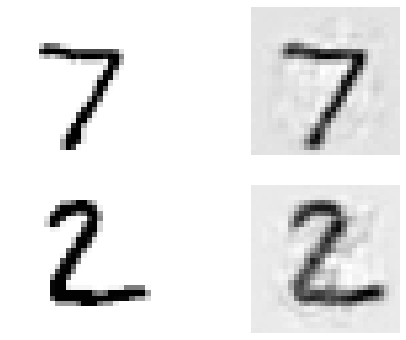

In [34]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [36]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 0.7047666 	희소 손실: 0.12352318 	전체 손실: 0.09142406
1 훈련 MSE: 0.704796 	희소 손실: 0.019605529 	전체 손실: 0.05858742
2 훈련 MSE: 0.7048345 	희소 손실: 0.028799854 	전체 손실: 0.054506186
3 훈련 MSE: 0.70477927 	희소 손실: 0.008937162 	전체 손실: 0.045784224
4 훈련 MSE: 0.70475614 	희소 손실: 0.07770297 	전체 손실: 0.05621028
5 훈련 MSE: 0.7046035 	희소 손실: 0.014777578 	전체 손실: 0.037430603
6 훈련 MSE: 0.7048179 	희소 손실: 0.010760792 	전체 손실: 0.032250192
7 훈련 MSE: 0.70467716 	희소 손실: 0.006685371 	전체 손실: 0.028559342
8 훈련 MSE: 0.70488346 	희소 손실: 0.014640239 	전체 손실: 0.027989157
9 훈련 MSE: 0.7049954 	희소 손실: 0.010540727 	전체 손실: 0.025672361
10 훈련 MSE: 0.70476043 	희소 손실: 0.017074438 	전체 손실: 0.025290703
11 훈련 MSE: 0.7047554 	희소 손실: 0.03934033 	전체 손실: 0.029316306
12 훈련 MSE: 0.70469606 	희소 손실: 0.019014362 	전체 손실: 0.024640704
13 훈련 MSE: 0.70488685 	희소 손실: 0.030627202 	전체 손실: 0.025302013
14 훈련 MSE: 0.70481926 	희소 손실: 0.014720345 	전체 손실: 0.020566199
15 훈련 MSE: 0.7045547 	희소 손실: 0.03210661 	전체 손실: 0.023378175
16 훈련 MSE: 0.7047551 	희소 손실: 0.016